In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.random.set_seed(100)

In [44]:
SPECTROGRAM_TRAIN_TFRECORD_FILENAME = "spectrogram_train.tfrecord"
SPECTROGRAM_VALID_TFRECORD_FILENAME = "spectrogram_valid.tfrecord"
SPECTROGRAM_TEST_TFRECORD_FILENAME = "spectrogram_test.tfrecord"
DATA_DIR = "data"
BUFFER_SIZE = 64
BATCH_SIZE = 64
SPECTROGRAM_SHAPE = (85, 129)

In [4]:
!nvidia-smi

Wed May 12 11:06:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:04:00.0 Off |                  N/A |
| 32%   30C    P8     6W / 120W |      0MiB /  6078MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 106...  Off  | 00000000:05:00.0 Off |                  N/A |
| 30%   

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU')]

# Load record

In [48]:
train_dataset = tf.data.TFRecordDataset([os.path.join(DATA_DIR, SPECTROGRAM_TRAIN_TFRECORD_FILENAME)])
valid_dataset = tf.data.TFRecordDataset([os.path.join(DATA_DIR, SPECTROGRAM_VALID_TFRECORD_FILENAME)])
test_dataset = tf.data.TFRecordDataset([os.path.join(DATA_DIR, SPECTROGRAM_TEST_TFRECORD_FILENAME)])

In [7]:
feature_description = {
    'spectrogram': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label': tf.io.FixedLenFeature([], tf.float32, default_value=0.0)
}

def _parse_function(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    spectrogram = tf.io.parse_tensor(example['spectrogram'], out_type=tf.float32)
    spectrogram = tf.ensure_shape(spectrogram, SPECTROGRAM_SHAPE)
    label = tf.ensure_shape(example['label'], ())
    return spectrogram, label

In [49]:
train_dataset = train_dataset.map(_parse_function)
valid_dataset = valid_dataset.map(_parse_function)
test_dataset = test_dataset.map(_parse_function)

In [9]:
for i in train_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(85, 129), dtype=float32, numpy=
array([[3.79017234e-01, 1.37462819e+00, 3.20527291e+00, ...,
        2.03023610e-05, 4.91823666e-05, 1.59546733e-04],
       [1.34324759e-01, 1.31664729e+00, 3.49691677e+00, ...,
        1.01808109e-04, 1.20156576e-04, 9.34302807e-05],
       [7.57609010e-02, 1.05255270e+00, 2.61501384e+00, ...,
        7.29629246e-05, 3.64155385e-05, 2.37822533e-05],
       ...,
       [3.68746817e-01, 1.46235037e+00, 3.51829767e+00, ...,
        4.68326034e-05, 5.54631079e-05, 7.57128000e-05],
       [6.25966415e-02, 9.80049014e-01, 2.85418606e+00, ...,
        8.71873126e-05, 1.01852413e-04, 8.16807151e-05],
       [3.01045269e-01, 1.19051707e+00, 2.84571457e+00, ...,
        4.19902790e-05, 1.61160388e-05, 2.91764736e-05]], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)


# Preparation

In [50]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(BUFFER_SIZE).cache()
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(BUFFER_SIZE).cache()
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(BUFFER_SIZE).cache()

# First model

Model parameters copied from tutorial: https://www.tensorflow.org/tutorials/audio/simple_audio

In [11]:
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_layer.adapt(train_dataset.map(lambda x, _: x))
model1 = tf.keras.models.Sequential([
    tf.keras.Input(shape=SPECTROGRAM_SHAPE),
    tf.keras.layers.Reshape((SPECTROGRAM_SHAPE[0], SPECTROGRAM_SHAPE[1], 1)),
    tf.keras.layers.experimental.preprocessing.Resizing(32, 32),
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 85, 129, 1)        0         
_________________________________________________________________
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 129)       259       
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        37184     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0

In [12]:
model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
               metrics=['accuracy'])

In [13]:
history1 = model1.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=tf.keras.callbacks.EarlyStopping(patience=2))

Epoch 1/20
163/163 [==============================] - 21s 90ms/step - loss: 471.9781 - accuracy: 0.8021 - val_loss: 0.3514 - val_accuracy: 0.8637
Epoch 2/20
163/163 [==============================] - 2s 12ms/step - loss: 0.3855 - accuracy: 0.8871 - val_loss: 0.2418 - val_accuracy: 0.9426
Epoch 3/20
163/163 [==============================] - 2s 12ms/step - loss: 0.2804 - accuracy: 0.9211 - val_loss: 0.2100 - val_accuracy: 0.9538
Epoch 4/20
163/163 [==============================] - 2s 12ms/step - loss: 0.2495 - accuracy: 0.9269 - val_loss: 0.2237 - val_accuracy: 0.9484
Epoch 5/20
163/163 [==============================] - 2s 12ms/step - loss: 0.2884 - accuracy: 0.9250 - val_loss: 0.1836 - val_accuracy: 0.9555
Epoch 6/20
163/163 [==============================] - 2s 12ms/step - loss: 0.2207 - accuracy: 0.9331 - val_loss: 0.1710 - val_accuracy: 0.9582
Epoch 7/20
163/163 [==============================] - 2s 12ms/step - loss: 0.2029 - accuracy: 0.9411 - val_loss: 0.1671 - val_accuracy: 0.9

# Primary analysis

Note that the base model already does pretty well, getting a validation accuracy of over 90%.

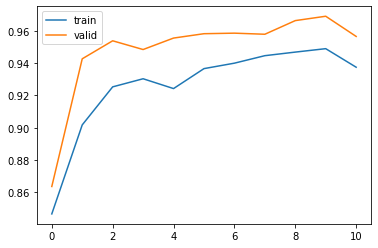

In [15]:
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='valid')
plt.legend()
plt.show()

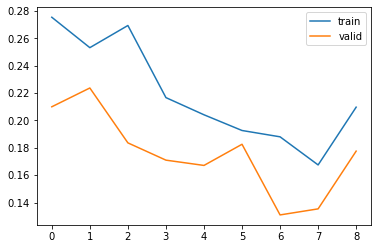

In [16]:
plt.plot(history1.history['loss'][2:], label='train')
plt.plot(history1.history['val_loss'][2:], label='valid')
plt.legend()
plt.show()

Note that the training error is much higher than validation. While this partly has to do with the fact that the validation error is calculated after an epoch, the gap still indicates that the model is severely underfitting. We will first address this by increasing the model's complexity. Clearly, the resizing to 32x32 causes a lot of data loss and adds bias. We also add an extra set of conv/pooling layers to account for the larger image.

In [17]:
model2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=SPECTROGRAM_SHAPE),
    tf.keras.layers.Reshape((SPECTROGRAM_SHAPE[0], SPECTROGRAM_SHAPE[1], 1)),
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, 1, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 85, 129, 1)        0         
_________________________________________________________________
normalization (Normalization multiple                  259       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 83, 127, 32)       37184     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 81, 125, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 62, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 62, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 62, 32)       

In [18]:
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
               metrics=['accuracy'])

In [19]:
history2 = model2.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=tf.keras.callbacks.EarlyStopping(patience=2))

Epoch 1/20
163/163 [==============================] - 49s 224ms/step - loss: 239.7868 - accuracy: 0.8400 - val_loss: 0.3490 - val_accuracy: 0.8778
Epoch 2/20
163/163 [==============================] - 20s 120ms/step - loss: 0.2508 - accuracy: 0.9376 - val_loss: 0.1761 - val_accuracy: 0.9349
Epoch 3/20
163/163 [==============================] - 20s 121ms/step - loss: 0.1760 - accuracy: 0.9479 - val_loss: 0.1745 - val_accuracy: 0.9440
Epoch 4/20
163/163 [==============================] - 20s 121ms/step - loss: 0.1325 - accuracy: 0.9629 - val_loss: 0.1115 - val_accuracy: 0.9632
Epoch 5/20
163/163 [==============================] - 20s 121ms/step - loss: 0.1343 - accuracy: 0.9631 - val_loss: 0.1019 - val_accuracy: 0.9656
Epoch 6/20
163/163 [==============================] - 20s 121ms/step - loss: 0.1053 - accuracy: 0.9693 - val_loss: 0.0812 - val_accuracy: 0.9727
Epoch 7/20
163/163 [==============================] - 20s 122ms/step - loss: 0.1253 - accuracy: 0.9669 - val_loss: 0.1363 - val_

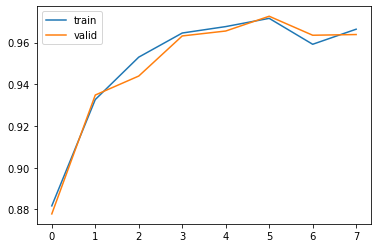

In [22]:
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='valid')
plt.legend()
plt.show()

Wow, this did better than I expected.

In [21]:
model2.evaluate(valid_dataset)

47/47 [==============================] - 2s 41ms/step - loss: 0.1377 - accuracy: 0.9639


[0.13773751258850098, 0.9638879299163818]

# Model size reduction

Right now, the model size is a bit too large, with 4 million parameters. It also takes 2 seconds to evaluate a batch - since each batch is worth 8 seconds of audio, this may become a significant bottleneck for realtime conversion of streamed data. We can reduce the number of parameters by increasing the pooling size.

In [23]:
model3 = tf.keras.models.Sequential([
    tf.keras.Input(shape=SPECTROGRAM_SHAPE),
    tf.keras.layers.Reshape((SPECTROGRAM_SHAPE[0], SPECTROGRAM_SHAPE[1], 1)),
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, 1, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 85, 129, 1)        0         
_________________________________________________________________
normalization (Normalization multiple                  259       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 83, 127, 32)       37184     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 81, 125, 64)       18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 41, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 27, 41, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 41, 32)       

In [24]:
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
               metrics=['accuracy'])

In [25]:
history3 = model3.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=tf.keras.callbacks.EarlyStopping(patience=2))

Epoch 1/20
163/163 [==============================] - 36s 170ms/step - loss: 62.9791 - accuracy: 0.8411 - val_loss: 0.2315 - val_accuracy: 0.9237
Epoch 2/20
163/163 [==============================] - 17s 107ms/step - loss: 0.2590 - accuracy: 0.9261 - val_loss: 0.2106 - val_accuracy: 0.9281
Epoch 3/20
163/163 [==============================] - 17s 107ms/step - loss: 0.2152 - accuracy: 0.9334 - val_loss: 0.1549 - val_accuracy: 0.9531
Epoch 4/20
163/163 [==============================] - 17s 107ms/step - loss: 0.1811 - accuracy: 0.9480 - val_loss: 0.1454 - val_accuracy: 0.9558
Epoch 5/20
163/163 [==============================] - 17s 107ms/step - loss: 0.1643 - accuracy: 0.9527 - val_loss: 0.1678 - val_accuracy: 0.9396
Epoch 6/20
163/163 [==============================] - 17s 107ms/step - loss: 0.1636 - accuracy: 0.9492 - val_loss: 0.1431 - val_accuracy: 0.9571
Epoch 7/20
163/163 [==============================] - 17s 107ms/step - loss: 0.1573 - accuracy: 0.9506 - val_loss: 0.1440 - val_a

While this did not decrease the performance, it also did not resolve its slowness problem by much. Indeed, it looks like the bottleneck is the size of the convolution layers. 

In [26]:
model4 = tf.keras.models.Sequential([
    tf.keras.Input(shape=SPECTROGRAM_SHAPE),
    tf.keras.layers.Reshape((SPECTROGRAM_SHAPE[0], SPECTROGRAM_SHAPE[1], 1)),
    norm_layer,
    tf.keras.layers.Conv2D(8, 3, activation='relu'),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 85, 129, 1)        0         
_________________________________________________________________
normalization (Normalization multiple                  259       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 83, 127, 8)        9296      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 81, 125, 16)       1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 41, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 27, 41, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 25, 39, 32)       

In [27]:
model4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
               metrics=['accuracy'])

In [28]:
history4 = model4.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=tf.keras.callbacks.EarlyStopping(patience=2))

Epoch 1/20
163/163 [==============================] - 31s 139ms/step - loss: 118.5807 - accuracy: 0.7416 - val_loss: 0.5163 - val_accuracy: 0.7776
Epoch 2/20
163/163 [==============================] - 12s 74ms/step - loss: 0.4689 - accuracy: 0.7938 - val_loss: 0.3709 - val_accuracy: 0.8680
Epoch 3/20
163/163 [==============================] - 12s 74ms/step - loss: 0.3655 - accuracy: 0.8425 - val_loss: 0.3414 - val_accuracy: 0.8633
Epoch 4/20
163/163 [==============================] - 12s 74ms/step - loss: 0.3411 - accuracy: 0.8449 - val_loss: 0.3275 - val_accuracy: 0.8657
Epoch 5/20
163/163 [==============================] - 12s 74ms/step - loss: 0.3287 - accuracy: 0.8518 - val_loss: 0.3166 - val_accuracy: 0.8741
Epoch 6/20
163/163 [==============================] - 12s 74ms/step - loss: 0.3205 - accuracy: 0.8610 - val_loss: 0.3056 - val_accuracy: 0.8704
Epoch 7/20
163/163 [==============================] - 12s 74ms/step - loss: 0.3226 - accuracy: 0.8619 - val_loss: 0.3013 - val_accura

Sadly, while this improves efficiency it falls short on performance.

# Final model

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=SPECTROGRAM_SHAPE),
    tf.keras.layers.Reshape((SPECTROGRAM_SHAPE[0], SPECTROGRAM_SHAPE[1], 1)),
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, 1, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 85, 129, 1)        0         
_________________________________________________________________
normalization (Normalization multiple                  259       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 83, 127, 32)       37184     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 81, 125, 64)       18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 27, 41, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 27, 41, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 27, 41, 32)       

In [40]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
               metrics=['accuracy'])

In [41]:
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset, 
                    callbacks=tf.keras.callbacks.ModelCheckpoint(filepath='model', monitor='val_accuracy', mode='max', save_best_only=True))

Epoch 1/50
163/163 [==============================] - 19s 110ms/step - loss: 98.6932 - accuracy: 0.8169 - val_loss: 0.3526 - val_accuracy: 0.8336
INFO:tensorflow:Assets written to: model/assets
Epoch 2/50
163/163 [==============================] - 18s 108ms/step - loss: 0.3490 - accuracy: 0.8837 - val_loss: 0.3461 - val_accuracy: 0.8934
INFO:tensorflow:Assets written to: model/assets
Epoch 3/50
163/163 [==============================] - 18s 108ms/step - loss: 0.2731 - accuracy: 0.9063 - val_loss: 0.1965 - val_accuracy: 0.9349
INFO:tensorflow:Assets written to: model/assets
Epoch 4/50
163/163 [==============================] - 18s 108ms/step - loss: 0.2090 - accuracy: 0.9304 - val_loss: 0.2589 - val_accuracy: 0.9065
Epoch 5/50
163/163 [==============================] - 18s 108ms/step - loss: 0.1778 - accuracy: 0.9422 - val_loss: 0.1511 - val_accuracy: 0.9514
INFO:tensorflow:Assets written to: model/assets
Epoch 6/50
163/163 [==============================] - 18s 108ms/step - loss: 0.159

In [42]:
saved_model = tf.keras.models.load_model('model')

In [51]:
saved_model.evaluate(test_dataset)

24/24 [==============================] - 6s 263ms/step - loss: 0.0321 - accuracy: 0.9899


[0.03211598098278046, 0.9898785352706909]

Since training is highly stochastic, we had to retrain the model several times to achieve this (only checking the validation results). The model acheives almost 99% on the test set, which is pretty nice!